---
title: "Predicting CCS values for TIMS data"

date: 2022-09-21

# date-modified: last-modified

author:

- name: Robbin Bouwmeester

  orcid: 0000-0001-6807-7029

  affiliations:
    - VIB-UGent Center for Medical Biotechnology, VIB, Belgium
    - Department of Biomolecular Medicine, Ghent University, Belgium

---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/ionmobility/_meier-tims-ccs.ipynb)

## Introduction

Ion mobility is a technique to separate ionized analytes based on their size, shape, and physicochemical properties. Initially the techniques for ion mobility propelled the ions with an electric field through a cell with inert gas. The ions collide with the inert gas without fragmentation. Separation is achieved by propelling the ions faster or slower in the electric field (i.e., based on their charge) and are slowed down by the collisions with the gas (i.e., based on shape and size). Trapped ion mobility (TIMS) reverses this operation by trapping the ions in an electric field and forcing them forward by collision with the gas. From any of the different ion mobility techniques you are able to derive the collisional cross section (CCS) in Angstrom squared. In this notebook you can follow a short tutorial on how to train a Machine Learning model for the prediction of these CCS values.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import pearsonr
import numpy as np
import re

vol_dict = {"A" : 88.6,
            "B" : 0.0,
            "O" : 0.0,
            "X" : 0.0,
            "J" : 0.0,
            "R" : 173.4,
            "N" : 114.1,
            "D" : 111.1,
            "C" : 108.5,
            "Q" : 143.8,
            "E" : 138.4,
            "G" : 60.1,
            "H" : 153.2,
            "I" : 166.7,
            "L" : 166.7,
            "K" : 168.6,
            "M" : 162.9,
            "F" : 189.9,
            "P" : 112.7,
            "S" : 89.0,
            "T" : 116.1,
            "W" : 227.8,
            "Y" : 193.6,
            "V" : 140}

aa_to_pos = dict(zip(vol_dict.keys(),range(len(vol_dict.keys()))))

## Data reading and preparation

Read the training data from [Meier et al.](https://doi.org/10.1038/s41467-021-21352-8)

In [2]:
ccs_df = pd.read_csv("/home/robbe/multioutput_prediction/aligned_with_multimodals_conformers_unique_grouped.csv", sep=";", converters= {"CCS":pd.eval} )

Execute the cell below to read a smaller data set from [Van Puyvelde et al.](https://www.nature.com/articles/s41597-022-01216-6). Remove all the "#" to read this smaller data set. On for example colab it is recommended to load this smaller data set. Please do note that the description is based on the larger data set. It is expected that more complex models do not benefit at the same rate from the smaller data set (e.g., the deep learning network). Hans Vissers from Waters analyzed this traveling wave IM data:

In [293]:
#ccs_df = pd.read_csv(
#    "https://github.com/ProteomicsML/ProteomicsML/raw/main/datasets/ionmobility/VanPuyvelde_TWIMS_CCS/TWIMSpeptideCCS.tsv.gz",
#    compression="gzip",
#    low_memory=False,
#    sep="\t"
#)

A small summarization of the data that was just read:

In [4]:
ccs_df.describe()

,Charge
count,119764.000000
mean,2.350389
std,0.550470
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


In [5]:
ccs_df

,Modified sequence,Charge,CCS
0,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,2,"[423.88222485441486, 423.88222485441486]"
1,_(Acetyl (Protein N-term))AAAAAAAAEQQSSNGPVKK_,2,"[497.1234509274718, 497.1234509274718]"
2,_(Acetyl (Protein N-term))AAAAAAAGDSDSWDADAFSV...,2,"[591.0205481362693, 591.0205481362693]"
3,_(Acetyl (Protein N-term))AAAAAAAGDSDSWDADAFSV...,3,"[671.4314940170556, 671.4314940170556]"
4,_(Acetyl (Protein N-term))AAAAAAAGDSDSWDADAFSV...,2,"[564.7157888795695, 564.7157888795695]"
...,...,...,...
119759,_YYYIPQYK_,2,"[378.1060543138916, 378.1060543138916]"
119760,_YYYQGCASWK_,2,"[402.5358455199179, 402.5358455199179]"
119761,_YYYVCQYCPAGNWANR_,2,"[479.4928567373948, 479.4928567373948]"
119762,_YYYVPADFVEYEK_,2,"[453.6371414660443, 453.6371414660443]"


Prepare the data to not contain any \"_\" characters or modifications in between \[ \]:

Count the occurence of amino acids, those that did not get detected; repace with 0

In [6]:
# Strip "_" from sequence
ccs_df["sequence"] = ccs_df["Modified sequence"].str.strip("_")

# Strip everything between "()" and "[]" from sequence
ccs_df["sequence"] = ccs_df["sequence"].str.replace(r"[\(\[].*?[\)\]]", "", regex=True)

In [7]:
ccs_df['Modified sequence'] = ccs_df['Modified sequence'].str.strip("_")
ccs_df['sequence'] = ccs_df['sequence'].str.replace(")", "")

In [8]:
# Parse modifications from Modified sequence
ccs_df['Modified sequence'] = ccs_df['Modified sequence'].str.replace('(Acetyl (Protein N-term))', '(ac)')
ccs_df['Modified sequence'] = ccs_df['Modified sequence'].str.replace('(Oxidation (M))', '(ox)')

In [9]:
def modifications(input_string):
    poslist = []
    modlist = []
    if "(ac)" in input_string:
        poslist.append(0)
        modlist.append('Acetyl')
        input_string_noac = input_string.replace('(ac)', '')
    else:
        input_string_noac = input_string

    while re.search("\(ox\)", input_string_noac):
        match = re.search("\(ox\)", input_string_noac)
        pos = match.span()[0]
        poslist.append(pos)
        modlist.append('Oxidation')
        input_string_noac = re.sub('\(ox\)', '', input_string_noac, count=1)

    C_positions = [pos for pos, char in enumerate(input_string_noac) if char == 'C']
    for i in C_positions:
        modlist.append("Carbamidomethyl")
        poslist.append(i+1)

    sortedposlist = sorted(poslist)
    sortedmodlist = [x for _, x in sorted(zip(poslist, modlist))]

    formattedlist = []
    for (pos, mod) in zip(sortedposlist, sortedmodlist):
        formattedlist.append(str(pos)+'|'+str(mod))

    output = '|'.join(formattedlist)
    return output


In [10]:
ccs_df['modifications'] = ccs_df['Modified sequence'].apply(modifications)
ccs_df['modifications'] = ccs_df['modifications'].replace('', np.nan)


In [11]:
ccs_df

,Modified sequence,Charge,CCS,sequence,modifications
0,(ac)AAAAAAAAAAGAAGGR,2,"[423.88222485441486, 423.88222485441486]",AAAAAAAAAAGAAGGR,0|Acetyl
1,(ac)AAAAAAAAEQQSSNGPVKK,2,"[497.1234509274718, 497.1234509274718]",AAAAAAAAEQQSSNGPVKK,0|Acetyl
2,(ac)AAAAAAAGDSDSWDADAFSVEDPVRK,2,"[591.0205481362693, 591.0205481362693]",AAAAAAAGDSDSWDADAFSVEDPVRK,0|Acetyl
3,(ac)AAAAAAAGDSDSWDADAFSVEDPVRK,3,"[671.4314940170556, 671.4314940170556]",AAAAAAAGDSDSWDADAFSVEDPVRK,0|Acetyl
4,(ac)AAAAAAAGDSDSWDADAFSVEDPVR,2,"[564.7157888795695, 564.7157888795695]",AAAAAAAGDSDSWDADAFSVEDPVR,0|Acetyl
...,...,...,...,...,...
119759,YYYIPQYK,2,"[378.1060543138916, 378.1060543138916]",YYYIPQYK,NaN
119760,YYYQGCASWK,2,"[402.5358455199179, 402.5358455199179]",YYYQGCASWK,6|Carbamidomethyl
119761,YYYVCQYCPAGNWANR,2,"[479.4928567373948, 479.4928567373948]",YYYVCQYCPAGNWANR,5|Carbamidomethyl|8|Carbamidomethyl
119762,YYYVPADFVEYEK,2,"[453.6371414660443, 453.6371414660443]",YYYVPADFVEYEK,NaN


In [12]:
# Apply counter to each sequence, fill NA with 0.0, make matrix from counts
X_matrix_count = pd.DataFrame(ccs_df["sequence"].apply(Counter).to_dict()).fillna(0.0).T

In [13]:
X_matrix_count

,A,G,R,E,Q,S,N,P,V,K,D,W,F,L,M,T,I,C,Y,H
0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119759,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
119760,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
119761,2.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0
119762,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


A fairly rudimentary technique is to use the volume of each amino acid and sum these volumes:

In [14]:
def to_predicted_ccs(row):
    vol_sum = sum([vol_dict[k]*v for k,v in row.to_dict().items()])
    return vol_sum

ccs_df["predicted_CCS_vol_based"] = X_matrix_count.apply(to_predicted_ccs,axis=1)

Lets see the results:

In [15]:
ccs_df_exploded = ccs_df.explode(column="CCS")

In [16]:
ccs_df_exploded

,Modified sequence,Charge,CCS,sequence,modifications,predicted_CCS_vol_based
0,(ac)AAAAAAAAAAGAAGGR,2,423.882225,AAAAAAAAAAGAAGGR,0|Acetyl,1416.9
0,(ac)AAAAAAAAAAGAAGGR,2,423.882225,AAAAAAAAAAGAAGGR,0|Acetyl,1416.9
1,(ac)AAAAAAAAEQQSSNGPVKK,2,497.123451,AAAAAAAAEQQSSNGPVKK,0|Acetyl,2076.9
1,(ac)AAAAAAAAEQQSSNGPVKK,2,497.123451,AAAAAAAAEQQSSNGPVKK,0|Acetyl,2076.9
2,(ac)AAAAAAAGDSDSWDADAFSVEDPVRK,2,591.020548,AAAAAAAGDSDSWDADAFSVEDPVRK,0|Acetyl,2970.8
...,...,...,...,...,...,...
119761,YYYVCQYCPAGNWANR,2,479.492857,YYYVCQYCPAGNWANR,5|Carbamidomethyl|8|Carbamidomethyl,2254.6
119762,YYYVPADFVEYEK,2,453.637141,YYYVPADFVEYEK,NaN,2002.1
119762,YYYVPADFVEYEK,2,453.637141,YYYVPADFVEYEK,NaN,2002.1
119763,YYYVQNVYTPVDEHVYPDHR,3,603.859828,YYYVQNVYTPVDEHVYPDHR,NaN,2967.8


/tmp/ipykernel_6613/1724546902.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


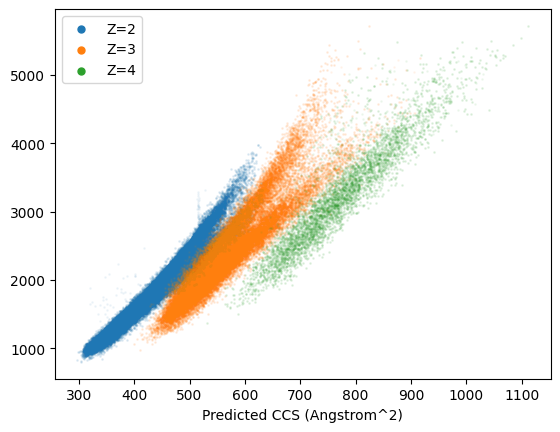

In [17]:
if len(ccs_df_exploded.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

for c in range(2,5):
    plt.scatter(
        ccs_df_exploded.loc[ccs_df_exploded["Charge"]==c,"CCS"],
        ccs_df_exploded.loc[ccs_df_exploded["Charge"]==c,"predicted_CCS_vol_based"],
        alpha=set_alpha,
        s=set_size,
        label="Z="+str(c)
    )

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

plt.xlabel("Observed CCS (Angstrom^2)")
plt.xlabel("Predicted CCS (Angstrom^2)")

plt.show()

Clear correlation, but seems we need to change the intercepts of each curve and make seperate predictions for each peptide charge state. In addition to these observations it seems that higher charge states have higher errors. This likely influenced by a large part by the relation between higher charge states and longer peptides. These longer peptides can deviate more from each other in terms of structures (and CCS). Instead of spending more time on this, lets have a look at a more ML-based approach.

## Training a linear regression model for CCS prediction

In [19]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression

import numpy as np
import random

In this section we will fit a linear regression model. This model is only able to fit a linear function between the features (sequence) and target (CCS). This linear model can be expressed as the following equation:

$ Y = \beta_0 + \beta_1  X$

Where $Y$ is a vector (/list) of all CCS values and X a matrix (/2-dimensional list) of all the amino acids counts. The intercept and weights of each features are learned so the predicted value ($\hat{Y}$) is close to the observed outcome ($Y$). What is considered close and how this closeness between predictions and observations are minimized is not further discussed here. However, there is a rich amount of information available on the internet (e.g., https://www.coursera.org/learn/machine-learning).

First, we will split the matrix into 90\% training peptides and 10\% testing peptides. These testing peptides are very valuable in estimating model performance. Since the model has not seen these sequences before it cannot overfit on these particular examples.

In [20]:
# Get all the index identifiers
all_idx = list(X_matrix_count.index)
random.seed(42)

# Shuffle the index identifiers so we can randomly split them in a testing and training set
random.shuffle(all_idx)

# Select 90 % for training and the remaining 10 % for testing
train_idx = all_idx[0:int(len(all_idx)*0.9)]
test_idx = all_idx[int(len(all_idx)*0.9):]

# Get the train and test indices and point to new variables
ccs_df_train = ccs_df.loc[train_idx,:]
ccs_df_test = ccs_df.loc[test_idx,:]

# Also for the feature matrix get the train and test indices
X_matrix_count_train = X_matrix_count.loc[train_idx,:]
X_matrix_count_test = X_matrix_count.loc[test_idx,:]

Now lets start training the models. Although we could encode the charge as a feature here we separate all models to counter any charge to composition specific patterns.

In [21]:
np.vstack(ccs_df_train.loc[ccs_df_train["Charge"]==2,"CCS"])

array([[389.37572821, 389.37572821],
       [483.44094244, 483.44094244],
       [398.43616957, 398.43616957],
       ...,
       [434.89106274, 434.89106274],
       [491.88568222, 491.88568222],
       [456.86205807, 456.86205807]])

In [22]:
# Initialize a model object
linear_model_z2 = LinearRegression()

# Fit the initialized model object to our training data (only charge 2)
linear_model_z2.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==2,:],
    y=np.vstack(ccs_df_train.loc[ccs_df_train["Charge"]==2,"CCS"])
)

# Repeat for the other two charge states
linear_model_z3 = LinearRegression()
linear_model_z3.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==3,:],
    y=np.vstack(ccs_df_train.loc[ccs_df_train["Charge"]==3,"CCS"])
)

linear_model_z4 = LinearRegression()
linear_model_z4.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==4,:],
    y=np.vstack(ccs_df_train.loc[ccs_df_train["Charge"]==4,"CCS"])
)

LinearRegression()

Now we can have a look at the coefficients $\beta_1$ learned. These should be highly correlated with the previous experimentally determined volumetric observations for each amino acid:

Observations are very similar. There are differences that could be cause by a multitude of reasons. For example, the difference between volumetric observations in the CCS cell is different or being part of a polypeptide chain changes the volume of the amino acid.

Next we will plot the predictions of the test set and compare them with observational data. Note that we apply each charge model seperately.

In [23]:
predictions = linear_model_z2.predict(X=X_matrix_count_test.loc[ccs_df["Charge"]==2,:])

In [24]:
difference_between_predictions = predictions[:, 0] - predictions[:,1]

(array([  1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          3.,   1.,   1.,   0.,   2.,   3.,   2.,  11.,   9.,  13.,   6.,
         18.,  34.,  46.,  54.,  78., 124., 121., 195., 260., 322., 374.,
        521., 588., 607., 698., 764., 777., 679., 615., 464., 374., 242.,
        149.,  81.,  54.,  17.,   4.,   3.]),
 array([-0.83421857, -0.81130302, -0.78838747, -0.76547193, -0.74255638,
        -0.71964083, -0.69672529, -0.67380974, -0.6508942 , -0.62797865,
        -0.6050631 , -0.58214756, -0.55923201, -0.53631646, -0.51340092,
        -0.49048537, -0.46756983, -0.44465428, -0.42173873, -0.39882319,
        -0.37590764, -0.3529921 , -0.33007655, -0.307161  , -0.28424546,
        -0.26132991, -0.23841436, -0.21549882, -0.19258327, -0.16966773,
        -0.14675218, -0.12383663, -0.10092109, -0.07800554, -0.05509   ,
        -0.03217445, -0.0092589 ,  0.01365664,  0.03657219,  0.05948774,
         0.08240328,  0.10531883,  0.12823437,  0.15114992,  0.17406547,
 

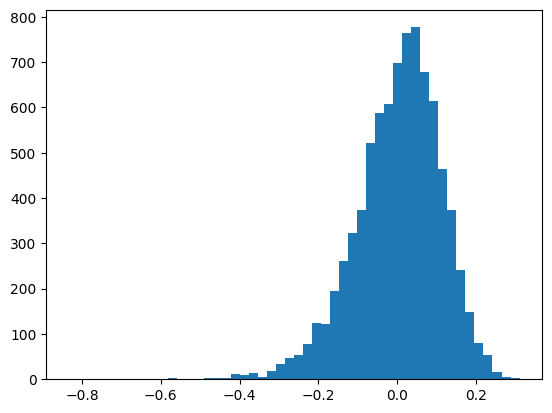

In [25]:
plt.hist(difference_between_predictions, bins=50)

It is clear that the predictions and observations are on the diagonal. This means that they are very similar. However, there are still some differences between observations and predictions.

In the previous example we trained models for charge state seperately. This is slightly inconvenient and other charge states might still be able to provide useful training examples. As long as the model corrects for the right charge state of course. In the next example we add charge state to the feature matrix. The linear model should be (partially...) able to account for the charge states of peptides.

In [26]:
# Make a new copy of feature matrix and add charge as a feature
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

In [27]:
# Fit the linear model, but this time with the charge as a feature
linear_model = LinearRegression()

linear_model.fit(
    X=X_matrix_count_charge_train,
    y=np.vstack(ccs_df_train.loc[:,"CCS"])
)

LinearRegression()

In [28]:
predictions = linear_model.predict(X=X_matrix_count_charge_test.loc[ccs_df["Charge"]==2,:])

In [29]:
difference_between_predictions = predictions[:, 0] - predictions[:,1]

(array([  2.,   8.,  14.,  47., 104., 220., 406., 611., 852., 982., 986.,
        921., 789., 636., 480., 365., 282., 206., 118.,  96.,  65.,  39.,
         25.,  20.,  16.,  10.,   3.,   2.,   6.,   1.,   2.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.91258541, -0.83244428, -0.75230316, -0.67216203, -0.5920209 ,
        -0.51187977, -0.43173864, -0.35159751, -0.27145638, -0.19131525,
        -0.11117412, -0.03103299,  0.04910813,  0.12924926,  0.20939039,
         0.28953152,  0.36967265,  0.44981378,  0.52995491,  0.61009604,
         0.69023717,  0.7703783 ,  0.85051942,  0.93066055,  1.01080168,
         1.09094281,  1.17108394,  1.25122507,  1.3313662 ,  1.41150733,
         1.49164846,  1.57178959,  1.65193071,  1.73207184,  1.81221297,
         1.8923541 ,  1.97249523,  2.05263636,  2.13277749,  2.21291862,
         2.29305975,  2.37320088,  2.453342  ,  2.53348313,  2.61362426,
 

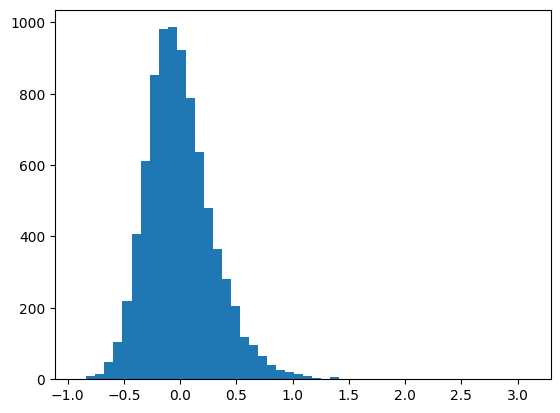

In [30]:
plt.hist(difference_between_predictions, bins=50)

With this model we are capable to predict CCS values for all three charge states (maybe more; be careful with extrapolation). However, it also shows that both z3 and z4 are not optimally predicted. Especially z4 we can probably draw a line manually that provides better performance than the current model. The incapability of the model to correctly predict some of these values is largely due to the linear algorithm. With this algorithm we can only fit "simple" linear relations, but more complex relations are not modeled correctly. In the next section we will fit a non-linear model that is able to capture these complex relations better. However, keep in mind that more complex models are usually also able to overfit data better, resulting in poorer generalization performance.

## Training an RF (non-linear) regression model for CCS prediction

In this section we will fit a random forest (RF) regression model. We hope to fit some of the non-linear relations present in the data. The RF algorithm fits multiple decision trees, but what makes these trees different is the random selection of instances (peptides) and/or features (amino acid count). The predictions between the forest of trees can be averaged to obtain a single prediction per peptide (instead of multiple for the same peptide). Later we will see that the algorithm might actually not be suitable for fitting this type of data.

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
# Make a new copy of feature matrix and add charge as a feature
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

In [33]:
# Initialize a RF object, note the hyperparameters that the model will follow
rf_model = RandomForestRegressor(
                max_depth=20,
                n_estimators=50,
                n_jobs=-1
)

# Fit the RF model
rf_model.fit(
    X=X_matrix_count_charge_train,
    y=np.vstack(ccs_df_train.loc[:,"CCS"])
)

RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=-1)

In [34]:
predictions = rf_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==2,:])

In [35]:
difference_between_predictions = predictions[:, 0] - predictions[:,1]

(array([2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 9.000e+00, 3.200e+01, 1.070e+02, 6.370e+02, 7.208e+03,
        2.040e+02, 4.400e+01, 2.300e+01, 8.000e+00, 6.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-34.99630933, -33.4867158 , -31.97712227, -30.46752874,
        -28.95793521, -27.44834168, -25.93874815, -24.42915462,
        -22.91956109, -21.40996756, -19.90037403, -18.3907805 ,
        -16.88118697, -15.37159344, -13.86199991, -12.35240638,
        -10.84281285,  -9.33321932,  -7.82362579,  -6.31403226,
         -4.80443873,  -3.2948452 ,  -1.78525167,  -0.27

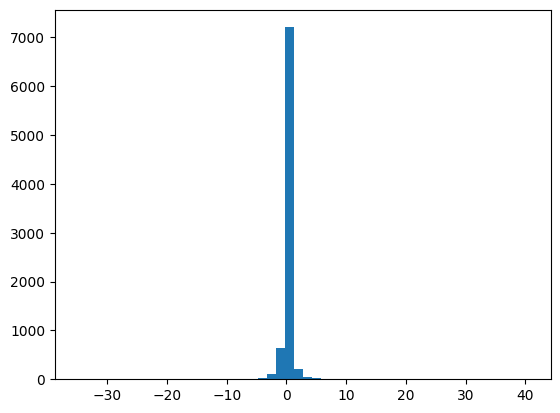

In [36]:
plt.hist(difference_between_predictions, bins=50)

In [37]:
# Evaluate predictions
targets = ccs_df_test.loc[ccs_df_test["Charge"]==2,"CCS"]
predictions = rf_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==2,:])

In [38]:
# Sort the values in each target list
sorted_targets = [sorted(x) for x in targets]
sorted_predictions = [sorted(x) for x in predictions]

In [39]:
# Calculate the error between every target and prediction
errors0 = [abs(x[0]-y[0]) for x,y in zip(sorted_targets,sorted_predictions)]
errors1 = [abs(x[1]-y[1]) for x,y in zip(sorted_targets,sorted_predictions)]

In [40]:
MAE0 = np.mean(errors0)
MAE1 = np.mean(errors1)
print(MAE0, MAE1)

18.13465785259534 18.257357333833678


In [41]:
# Add predictions to dataframe
ccs_df_test.loc[ccs_df_test["Charge"]==2,"predicted_CCS_RF"] = predictions[:,0]
ccs_df_test.loc[ccs_df_test["Charge"]==2,"predicted_CCS_RF_2"] = predictions[:,1]

In [42]:
ccs_df_test['Difference_RF'] = ccs_df_test['predicted_CCS_RF'] - ccs_df_test['predicted_CCS_RF_2']

As can be observed the problem with z=4 splitting up is gone, probably due to the capability of RF to fit non-linear relations. However, we see quite a large deviation on the diagonal. One of the major causes of this problem is the exclusion of amino acid counts for the decision trees. Although this is fundamental to the inner workings of RF, it means that we cannot take the excluded amino acids into account and these values are likely to be replaced by average expected volume to other (non-excluded) amino acids. RF performs very well when features correlate, and predictions are not fully dependent on the inclusion of all features. Next we will look at a decision tree algorithm (XGBoost) that does not rely on the exclusion of features.

PS note that you might be able to fit a much better model by using a much larger number of trees, but overall the problem largely remains, and it is better to choose an algorithm that respects/fits your data best.

## Training a XGBoost (non-linear) regression model for CCS prediction

In this section we will fit a XGBoost regression model. This algorithm works by training a sequence of underfitted models. Each model in the sequence receives the output of the previous decision tree models. This combination of trees allows to fit the data well without greatly overfitting it.

In [43]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

In [44]:
# Make a new copy of feature matrix and add charge as a feature
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

In [45]:
target_1 = []
target_2 = []
for lst in ccs_df_train.loc[:,"CCS"]:
    target_1.append(lst[0])
    target_2.append(lst[1])

ccs_df_train["CCS_1"] = target_1
ccs_df_train["CCS_2"] = target_2

In [46]:
test_target_1 = []
test_target_2 = []
for lst in ccs_df_test.loc[:,"CCS"]:
    test_target_1.append(lst[0])
    test_target_2.append(lst[1])

ccs_df_test["CCS_1"] = test_target_1
ccs_df_test["CCS_2"] = test_target_2

In [47]:
# Initialize the XGB object
xgb_model = XGBRegressor(
                max_depth=12,
                n_estimators=250,
                tree_method="hist",
)

multioutput_regressor = MultiOutputRegressor(xgb_model)

# Fit the XGB model
xgb_model.fit(
    X_matrix_count_charge_train,
    ccs_df_train.loc[:,["CCS_1", "CCS_2"]]
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
# Get dataframe with predictions
predictions = xgb_model.predict(X_matrix_count_charge_test)

# Add predictions to dataframe
ccs_df_test["predicted_CCS_XGB_1"] = predictions[:,0]
ccs_df_test["predicted_CCS_XGB_2"] = predictions[:,1]

# Get difference between predictions
ccs_df_test['Difference_XGB'] = ccs_df_test['predicted_CCS_XGB_1'] - ccs_df_test['predicted_CCS_XGB_2']


<Axes: >

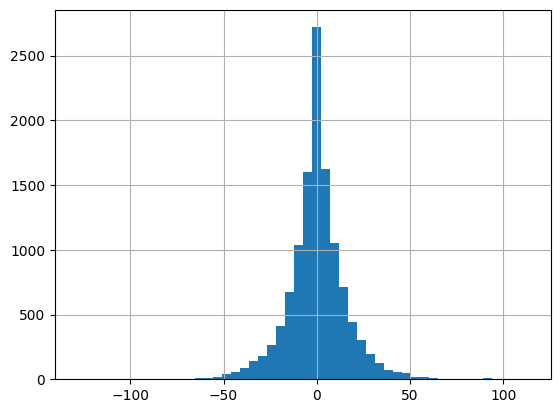

In [50]:
ccs_df_test['Difference_XGB'].hist(bins=50)

In [51]:
# Evaluate predictions
targets = ccs_df_test.loc[ccs_df_test["Charge"]==2,["CCS_1", "CCS_2"]]
predictions = xgb_model.predict(X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==2,:])

# Sort the values in each target list
sorted_targets = [sorted(x) for x in targets.values]
sorted_predictions = [sorted(x) for x in predictions]

# Calculate the error between every target and prediction
errors0 = [abs(x[0]-y[0]) for x,y in zip(sorted_targets,sorted_predictions)]
errors1 = [abs(x[1]-y[1]) for x,y in zip(sorted_targets,sorted_predictions)]

MAE0 = np.mean(errors0)
MAE1 = np.mean(errors1)

print(MAE0, MAE1)

10.959399695439973 10.986365839952


## Training a deep learning LSTM model for CCS prediction

The deviation on the diagonal has been decreased significantly. But... A decision tree based algorithm is usually not the best for a regression model. Since the target data is continuous a model that can respect this structure is likely to perform better. Furthermore, up till now we simply counted amino acids, but structure is important. So to get the most out of the data we need to use the exact positions of amino acids.

Also... We have a lot of data it makes sense to use deep learning (DL). DL models are usually capable of learning more complex relations than traditional algorithms. Furthormore, for traditional ML algorithms we usually need to engineer features, while DL can usually work directly from raw data. DL is able to construct its own features.

In [ ]:
from tensorflow.keras.layers import Dense, concatenate, Input, Bidirectional, LSTM
from tensorflow.keras.models import Model
import tensorflow as tf

As mentioned before, we want to use features that can also tell us something about the potential structure of the peptide. This means we need to take the sequence of the peptide into account and not just the amino acid counts. For this we will use a 'one-hot encoding', in this matrix each position in the peptide are the columns (number of columns equals the length of the peptide) and each amino acid per position has its own row (for the standard amino acids this is 20). So as a result we create a matrix that is the length of the peptide by the amount of unique amino acids in the whole data set. For each position we indicate the presence with a '1' and absence with '0'. As a result the sum of each columnn is '1' and the sum of the whole matrix equals the length of the peptide.

In [ ]:
def aa_seq_to_one_hot(seq,padding_length=60):
    # Although padding is not needed for an LSTM, we might need it if we for example apply a CNN
    # Calculate how much padding is needed
    seq_len = len(seq)
    if seq_len > padding_length:
        seq = seq[0:padding_length]
        seq_len = len(seq)

    # Add padding for peptides that are too short
    padding = "".join(["X"] * (padding_length - len(seq)))
    seq = seq + padding

    # Initialize all feature matrix
    matrix_hc = np.zeros(
        (len(aa_to_pos.keys()), len(seq)), dtype=np.int8)

    # Fill the one-hot matrix, when we encounter an 'X' it should be the end of the sequence
    for idx,aa in enumerate(seq):
        if aa == "X":
            break
        matrix_hc[aa_to_pos[aa],idx] = 1

    return matrix_hc

In [ ]:
# Calculate the one-hot matrices and stack them
# Result is a 3D matrix where the first dimension is each peptide, and then the last two dims are the one-hot matrix
one_hot_encoded_train = np.stack(ccs_df_train["sequence"].apply(aa_seq_to_one_hot).values)
one_hot_encoded_test = np.stack(ccs_df_test["sequence"].apply(aa_seq_to_one_hot).values)

In [ ]:
if len(ccs_df.index) < 1e4:
    epochs = 100
    num_lstm = 12
    batch_size = 128
else:
    batch_size = 1024
    epochs = 10
    num_lstm = 64

batch_size = 128
v_split    = 0.1
optimizer  = "adam"
loss       = "mean_squared_error"

# The architecture chosen consists of two inputs: (1) the one-hot matrix and (2) the charge
# The first part is a biderectional LSTM (a), in paralel we have dense layers containing the charge (b)
# Both a and b are concatenated to go through several dense layers (c)
input_a = Input(shape=(None, one_hot_encoded_train.shape[2]))
a = Bidirectional(LSTM(num_lstm,return_sequences=True))(input_a)
a = Bidirectional(LSTM(num_lstm))(a)
a = Model(inputs=input_a, outputs=a)

input_b = Input(shape=(1,))
b = Dense(5, activation="relu")(input_b)
b = Model(inputs=input_b, outputs=b)

c = concatenate([a.output, b.output],axis=-1)

c = Dense(64, activation="relu")(c)
c = Dense(32, activation="relu")(c)
c = Dense(1, activation="relu")(c)

# Create the model with specified inputs and outputs
model = Model(inputs=[a.input, b.input], outputs=c)

model.compile(optimizer=optimizer, loss=loss)

# Fit the model on the training data
history = model.fit(
            (one_hot_encoded_train,ccs_df_train.loc[:,"Charge"]),
            ccs_df_train.loc[:,"CCS"],
            epochs=epochs,
            batch_size=batch_size,
            validation_split=v_split
)

Epoch 1/10
4550/4550 [==============================] - 108s 23ms/step - loss: 5536.7256 - val_loss: 467.1984
Epoch 2/10
4550/4550 [==============================] - 102s 22ms/step - loss: 436.4136 - val_loss: 403.9187
Epoch 3/10
4550/4550 [==============================] - 100s 22ms/step - loss: 395.7551 - val_loss: 384.5470
Epoch 4/10
4550/4550 [==============================] - 103s 23ms/step - loss: 376.4315 - val_loss: 382.0145
Epoch 5/10
4550/4550 [==============================] - 102s 23ms/step - loss: 364.8819 - val_loss: 395.8338
Epoch 6/10
4550/4550 [==============================] - 106s 23ms/step - loss: 357.4092 - val_loss: 355.8185
Epoch 7/10
4550/4550 [==============================] - 104s 23ms/step - loss: 342.5216 - val_loss: 312.9571
Epoch 8/10
4550/4550 [==============================] - 104s 23ms/step - loss: 275.4517 - val_loss: 274.8963
Epoch 9/10
4550/4550 [==============================] - 110s 24ms/step - loss: 253.2955 - val_loss: 252.0118
Epoch 10/10
4550/4

In [ ]:
# Predict CCS values test set
ccs_df_test["LSTM_predictions"] = model.predict((one_hot_encoded_test,ccs_df_test.loc[:,"Charge"]))

2247/2247 [==============================] - 20s 8ms/step


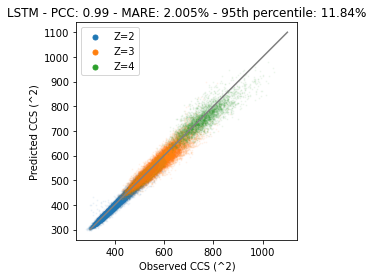

In [ ]:
if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_df_test.loc[ccs_df_test["Charge"]==2,"CCS"],
    ccs_df_test.loc[ccs_df_test["Charge"]==2,"LSTM_predictions"],
    alpha=set_alpha,
    s=set_size,
    label="Z=2"
)

plt.scatter(
    ccs_df_test.loc[ccs_df_test["Charge"]==3,"CCS"],
    ccs_df_test.loc[ccs_df_test["Charge"]==3,"LSTM_predictions"],
    alpha=set_alpha,
    s=set_size,
    label="Z=3"
)

plt.scatter(
    ccs_df_test.loc[ccs_df_test["Charge"]==4,"CCS"],
    ccs_df_test.loc[ccs_df_test["Charge"]==4,"LSTM_predictions"],
    alpha=set_alpha,
    s=set_size,
    label="Z=4"
)

# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_df_test["LSTM_predictions"]
mare = round(sum((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100)/len(predictions),3)
pcc = round(pearsonr(predictions,ccs_df_test.loc[:,"CCS"])[0],3)
perc_95 = round(np.percentile((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100,95)*2,2)

plt.title(f"LSTM - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}%")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

It is clear that the performance of this model is much better. But... Performance can be improved a lot more by for example tuning hyperparameters like the network architecture or number of epochs.

Hope you enjoyed this tutorial! Feel free to edit it and make a pull request!